In [1]:
!nvidia-smi


Thu May  2 08:06:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P0              20W /  80W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<a id="lib"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Importing Required Libraries</b></div> 

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

from matplotlib import rcParams

import matplotlib.patches as patches
from math import ceil

<a id="labels"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Loading Labels</b></div> 

In [3]:
label_data = pd.read_csv('data/stage_2_train_labels.csv')
columns = ['patientId', 'Target']
all_data = label_data

label_data = label_data.filter(columns)
label_data.head(5)
#print(all_data)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


<a id="split"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Spliting Train and Validation Sets</b></div> 

In [4]:
train_labels, val_labels = train_test_split(label_data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


In [5]:
print(f'patientId: {train_labels[0][0]}, Target: {train_labels[0][1]}')

patientId: a24b4ad9-13df-42a1-9e3e-f92c9682b64f, Target: 1


In [6]:
train_f = 'data/stage_2_train_images'
test_f = 'data/stage_2_test_images'

train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]

print(len(train_paths))
print(len(val_paths))

27204
3023


<a id="sample"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Checking Some Samples from Dataset</b></div> 

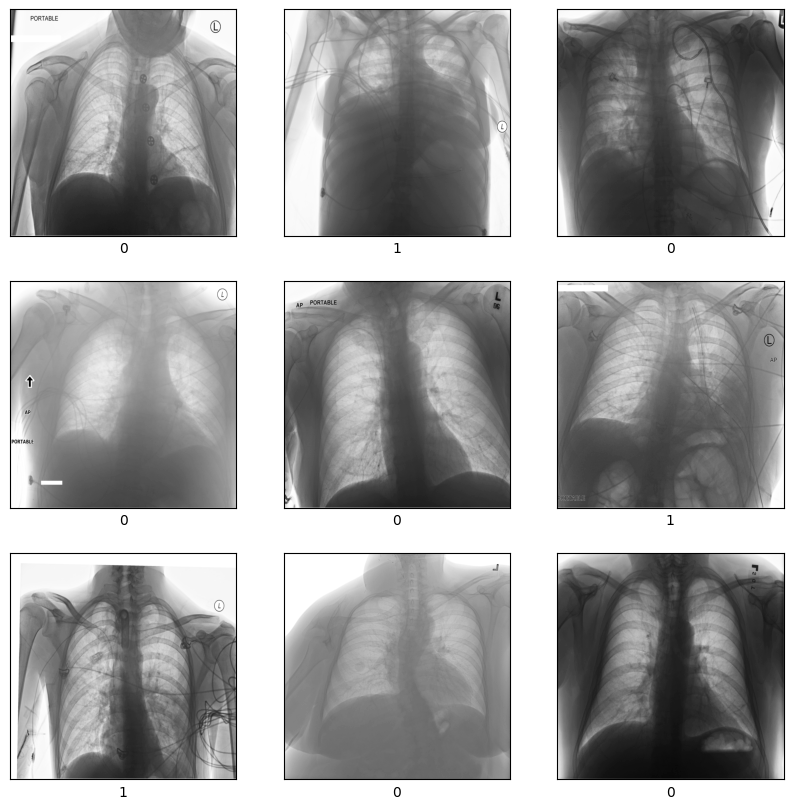

In [7]:
def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])

imshow()

<a id="trans"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Composing Transformations</b></div>  

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()])

<a id="data"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Writing a Custom Dataset Function</b></div>   

In [9]:
class Dataset(data.Dataset):
    
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')

        label = self.labels[index][1]
        
        if self.transform is not None:
            image = self.transform(image)
        
        
        name = self.paths[index].split("/")[-1]
        GH = all_data['patientId']==name
        FIL = all_data[GH]
        #print("From the datset loader, name", name)
        box = [FIL['x'].values[0], FIL['y'].values[0], FIL['width'].values[0], FIL['height'].values[0]]
            
        return image, label, box
    
    def __len__(self):
        
        return len(self.paths)

In [10]:
class Dataset(data.Dataset):
    
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')

        label = self.labels[index][1]
        
        if self.transform is not None:
            image = self.transform(image)
        
        name = self.paths[index].split("/")[-1]
        GH = all_data['patientId'] == name
        FIL = all_data[GH]
        
        if not FIL.empty:
            box = [FIL['x'].values[0], FIL['y'].values[0], FIL['width'].values[0], FIL['height'].values[0]]
        else:
            # Provide a default value for box if FIL is empty
            box = [0, 0, 0, 0]
            
        return image, label, box
    
    def __len__(self):
        return len(self.paths)


## Prepare training and validation dataloader

In [11]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

## Specify device object

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<a id="model"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Loading a Pre-trained ResNet18 Model and its Fine-tuning</b></div>    

In [13]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\dhanu\.conda\envs\idk_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dhanu\.conda\envs\idk_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<a id="train"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Training the Model</b></div>    

In [15]:

num_epochs = 5
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    # Training step
    for i, (images, labels, _) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 2000 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # Validation step
    correct = 0
    total = 0
    for images, labels, _ in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch + 1}/{num_epochs}, Val_Acc: {100 * correct / total}')

213it [13:08,  3.70s/it]
100%|██████████| 24/24 [01:32<00:00,  3.86s/it]


Epoch: 1/5, Val_Acc: 81.11148071289062


213it [24:28,  6.89s/it] 
100%|██████████| 24/24 [01:19<00:00,  3.31s/it]


Epoch: 2/5, Val_Acc: 81.1776351928711


213it [17:48,  5.02s/it]
100%|██████████| 24/24 [01:37<00:00,  4.08s/it]


Epoch: 3/5, Val_Acc: 80.91300201416016


213it [23:21,  6.58s/it]
100%|██████████| 24/24 [01:42<00:00,  4.28s/it]


Epoch: 4/5, Val_Acc: 81.872314453125


213it [17:56,  5.06s/it]
100%|██████████| 24/24 [01:42<00:00,  4.26s/it]


Epoch: 5/5, Val_Acc: 81.80615234375


<a id="test"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Testing the Model</b></div>    

In [16]:
if 0:
    model.eval()

    correct = 0
    total = 0
    for images, labels, _ in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Val_Acc: {100 * correct / total}')

<a id="save"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Save the Model Weights</b></div>      

In [17]:
torch.save(model.state_dict(), 'model_weights/weights_only.pth')
torch.save(model, 'models/model.pth')
print("Model and weights saved.")

Model and weights saved.


<a id="load"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Loading Saved Model</b></div>     

In [18]:
model = torch.load('models/model.pth')

In [19]:
model.eval()

correct = 0
total = 0  
for images, labels, _ in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
print(f'Val_Acc: {100*correct/total}')

100%|██████████| 24/24 [01:42<00:00,  4.25s/it]


Val_Acc: 81.80615234375


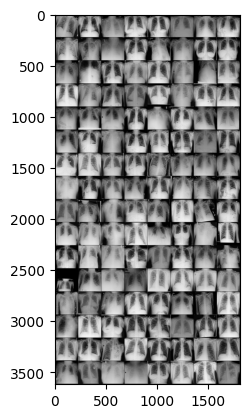

In [45]:
batch = iter(train_loader)
images, labels,_ = next(batch)

image_grid = torchvision.utils.make_grid(images)
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)
plt.show()

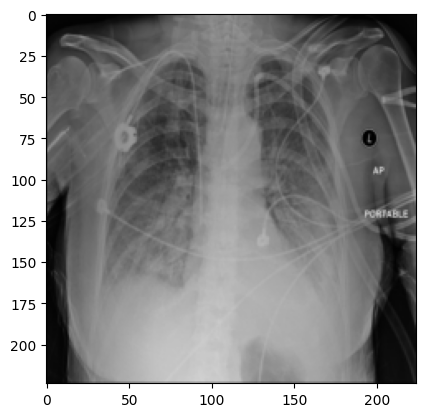

Label: tensor(1)


In [56]:
batch = iter(val_loader)
images, labels, box= next(batch)


single_image = images[127]  

# Convert the single image to a grid
image_grid = torchvision.utils.make_grid(single_image)

# Convert to numpy and transpose
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))

# Visualize the single image
plt.imshow(img)
plt.show()
print("Label:", labels[127])